<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/CIFAR100_Final_implementation_and_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/colorization'

Mounted at /content/drive
/content/drive/MyDrive/colorization


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [3]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using CIFAR100

In [4]:
class labColorizationDataset(Dataset):
    def __init__(self,root='./data', train=True, transform=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))

        return L, ab

In [5]:
train_data = labColorizationDataset(
    root='./data',
    train=True,
    transform = None
)

test_data = labColorizationDataset(
    root='./data',
    train=False,
    transform = None
)
len(train_data), len(test_data)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [ ]:
gray, chrome = train_data[69]
gray.shape, chrome.shape

(torch.Size([1, 32, 32]), torch.Size([2, 32, 32]))

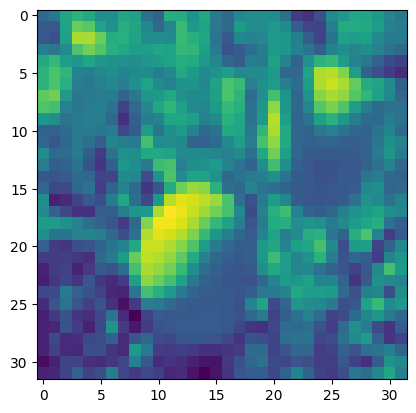

In [ ]:
plt.imshow(gray[0])

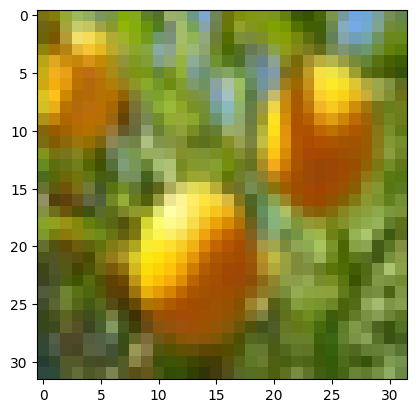

In [ ]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# II. Preparing the Model

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if self.batch_norm:
          self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        if self.batch_norm:
          x = self.bn(x)
        return x


In [7]:
class SkipDecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels + out_channels, out_channels, batch_norm)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1), dim=-3)
        y = self.conv(y2)
        return y

class NoSkipDecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(out_channels, out_channels, batch_norm)

    def forward(self, x):
        y1 = self.up_conv(x)
        y = self.conv(y1)
        return y

In [8]:
class UNet(nn.Module):
    def __init__(self, size, skip, batch_norm=False):
        super().__init__()
        self.skip = skip

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)

        # trainable layers
        ## encoder
        self.en_conv1 = DoubleConv(1,size, batch_norm)
        self.en_conv2 = DoubleConv(size,size*2, batch_norm)
        self.en_conv3 = DoubleConv(size*2,size*4, batch_norm)
        self.en_conv4 = DoubleConv(size*4,size*8, batch_norm)

        ## bottleneck
        self.conv = DoubleConv(size*8,size*16, batch_norm)

        ## decoder
        self.de_conv4 = SkipDecoderConv(size*16,size*8, batch_norm) if self.skip else NoSkipDecoderConv(size*16,size*8, batch_norm)
        self.de_conv3 = SkipDecoderConv(size*8,size*4, batch_norm) if self.skip else NoSkipDecoderConv(size*8,size*4, batch_norm)
        self.de_conv2 = SkipDecoderConv(size*4,size*2, batch_norm) if self.skip else NoSkipDecoderConv(size*4,size*2, batch_norm)
        self.de_conv1 = SkipDecoderConv(size*2,size, batch_norm) if self.skip else NoSkipDecoderConv(size*2,size, batch_norm)

        ## reconstruct layer
        self.reconstruct = nn.Conv2d(size, 2, kernel_size=3, padding=1)

    def forward(self, x):
      # encoder inference
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        e3 = self.en_conv3(p2)
        p3 = self.pool(e3)
        e4 = self.en_conv4(p3)
        p4 = self.pool(e4)
      # bottleneck inference
        b = self.conv(p4)
      # decoder inference
        d4 = self.de_conv4(b,e4) if self.skip else self.de_conv4(b)
        d3 = self.de_conv3(d4,e3) if self.skip else self.de_conv3(d4)
        d2 = self.de_conv2(d3,e2) if self.skip else self.de_conv2(d3)
        d1 = self.de_conv1(d2,e1) if self.skip else self.de_conv1(d2)

      # reconstruct image
        colors = self.reconstruct(d1)
        # print(colored_image.shape)

        return colors

# III. Training Experimentation

## 0. utils

In [9]:
from tqdm import tqdm

def train_loop(model, loader, optimizer, backprop_loss=1):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0

    for grayscale_images, colored_images in tqdm(loader, leave=False):
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss1 = nn.L1Loss()(predicted_images, colored_images)
        loss2 = nn.MSELoss()(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss = loss1 + loss2 if backprop_loss==0 else loss1 if backprop_loss==1 else loss2
        loss.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        running_loss2 += loss2.item()

    # Calculate average loss
    average_loss1 = running_loss1 / len(loader)
    average_loss2 = running_loss2 / len(loader)

    return average_loss1, average_loss2

def plot_loss(loss, title, save_path):
    epochs = range(len(loss))

    # Plotting the losses
    plt.plot(epochs, loss)
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)

    # Save the plot
    plt.savefig(save_path)
    plt.show()

    # Close the plot to free up resources
    plt.close()


# Train optimal architecture of model (based on previous analysis)

In [24]:
# config
model_name = 'FINAL-CIFAR-L2'
model_size = 64
skip_connections = True
batch_norm = True
backprop_loss = 2
batch_size = 256


# Initialize U-Net model and loader and optimizer
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = UNet(model_size, skip_connections, batch_norm)
model.to(device)

optimizer = optim.Adam(model.parameters())

# training loop
l1_hist = []
l2_hist = []

In [25]:
epochs = 50
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/50:  MAE Loss: 10.452095430724475, MSE Loss: 243.28490035387935


Epoch 2/50:  MAE Loss: 10.11163243468927, MSE Loss: 224.57099712138273


Epoch 3/50:  MAE Loss: 9.984166490788363, MSE Loss: 218.64174776661153


Epoch 4/50:  MAE Loss: 9.902430904154874, MSE Loss: 214.60556980055205


Epoch 5/50:  MAE Loss: 9.786106119350512, MSE Loss: 209.8140537495516


Epoch 6/50:  MAE Loss: 9.68262294847138, MSE Loss: 204.79886432569853


Epoch 7/50:  MAE Loss: 9.567194598061699, MSE Loss: 199.45861473862007


Epoch 8/50:  MAE Loss: 9.475653273718697, MSE Loss: 195.10968788302674


Epoch 9/50:  MAE Loss: 9.353803006970153, MSE Loss: 189.5905172386948


Epoch 10/50:  MAE Loss: 9.180012240701792, MSE Loss: 181.41675108306262


Epoch 11/50:  MAE Loss: 8.988868105168246, MSE Loss: 173.40090919027523


Epoch 12/50:  MAE Loss: 8.770972621684171, MSE Loss: 164.24263459808972


Epoch 13/50:  MAE Loss: 8.5027593641865, MSE Loss: 154.30136626107353


Epoch 14/50:  MAE Loss: 8.21696030850313, MSE Loss: 143.9306578733483


Epoch 15/50:  MAE Loss: 7.937518051692417, MSE Loss: 134.42774328893546


Epoch 16/50:  MAE Loss: 7.6637281714653485, MSE Loss: 125.49627946347607


Epoch 17/50:  MAE Loss: 7.418474657194955, MSE Loss: 117.49738233916614


Epoch 18/50:  MAE Loss: 7.1843700749533514, MSE Loss: 110.26046542732082


Epoch 19/50:  MAE Loss: 6.985702711708692, MSE Loss: 104.27506750457141


Epoch 20/50:  MAE Loss: 6.792035538323072, MSE Loss: 98.58457347324916


Epoch 21/50:  MAE Loss: 6.6114265529476866, MSE Loss: 93.5263731430988


Epoch 22/50:  MAE Loss: 6.473350442185694, MSE Loss: 89.70299362649723


Epoch 23/50:  MAE Loss: 6.315080053952276, MSE Loss: 85.50313330669792


Epoch 24/50:  MAE Loss: 6.1749659582060215, MSE Loss: 81.96532229987942


Epoch 25/50:  MAE Loss: 6.039589392895601, MSE Loss: 78.57724002915985


Epoch 26/50:  MAE Loss: 5.918991906302316, MSE Loss: 75.77645763085813


Epoch 27/50:  MAE Loss: 5.8471434335319366, MSE Loss: 73.89176209118901


Epoch 28/50:  MAE Loss: 5.743922620403524, MSE Loss: 71.54223794353251


Epoch 29/50:  MAE Loss: 5.6662412006027845, MSE Loss: 69.76987593514579


Epoch 30/50:  MAE Loss: 5.577985432683205, MSE Loss: 67.69107069287982


Epoch 31/50:  MAE Loss: 5.511607880495032, MSE Loss: 66.02258232661656


Epoch 32/50:  MAE Loss: 5.4506911306965105, MSE Loss: 64.5686169449164


Epoch 33/50:  MAE Loss: 5.390893116289256, MSE Loss: 63.058914067793864


Epoch 34/50:  MAE Loss: 5.351494010613889, MSE Loss: 61.980949051526125


Epoch 35/50:  MAE Loss: 5.282022454300705, MSE Loss: 60.42236316447355


Epoch 36/50:  MAE Loss: 5.225597931414234, MSE Loss: 59.026080501322845


Epoch 37/50:  MAE Loss: 5.166800194857072, MSE Loss: 57.63802057383012


Epoch 38/50:  MAE Loss: 5.10834322656904, MSE Loss: 56.240704361273316


Epoch 39/50:  MAE Loss: 5.0518560385217475, MSE Loss: 54.80898724770059


Epoch 40/50:  MAE Loss: 4.986119749594708, MSE Loss: 53.43490939237633


Epoch 41/50:  MAE Loss: 4.91606591185745, MSE Loss: 51.913990701947895


Epoch 42/50:  MAE Loss: 4.871076875803422, MSE Loss: 50.93930415717923


Epoch 43/50:  MAE Loss: 4.826047033679728, MSE Loss: 49.91854122706822


Epoch 44/50:  MAE Loss: 4.772410901225343, MSE Loss: 48.76770496368408


Epoch 45/50:  MAE Loss: 4.708683047975812, MSE Loss: 47.40992333937665


Epoch 46/50:  MAE Loss: 4.637917876243591, MSE Loss: 46.03179923855529


Epoch 47/50:  MAE Loss: 4.628902282033648, MSE Loss: 45.72001073798355


Epoch 48/50:  MAE Loss: 4.597830176353455, MSE Loss: 45.0446905019332


Epoch 49/50:  MAE Loss: 4.569747394444991, MSE Loss: 44.37970836795106


Epoch 50/50:  MAE Loss: 4.505139900713551, MSE Loss: 43.19611559108812


In [29]:
epochs = 10
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/10:  MAE Loss: 4.13729421703183, MSE Loss: 36.139484901817475


Epoch 2/10:  MAE Loss: 4.093823106921449, MSE Loss: 35.42499833204308


Epoch 3/10:  MAE Loss: 4.064223789438909, MSE Loss: 34.885370789741984


Epoch 4/10:  MAE Loss: 4.030083031070475, MSE Loss: 34.309730140530334


Epoch 5/10:  MAE Loss: 4.011863181785661, MSE Loss: 33.9568412157954


Epoch 6/10:  MAE Loss: 4.001821048405706, MSE Loss: 33.73971373694284


Epoch 7/10:  MAE Loss: 3.9806757265207717, MSE Loss: 33.36946828024728


Epoch 8/10:  MAE Loss: 3.930291304782945, MSE Loss: 32.569049611383555


Epoch 9/10:  MAE Loss: 3.935742974281311, MSE Loss: 32.60230148081877


Epoch 10/10:  MAE Loss: 3.9009489806330935, MSE Loss: 32.02070433752878


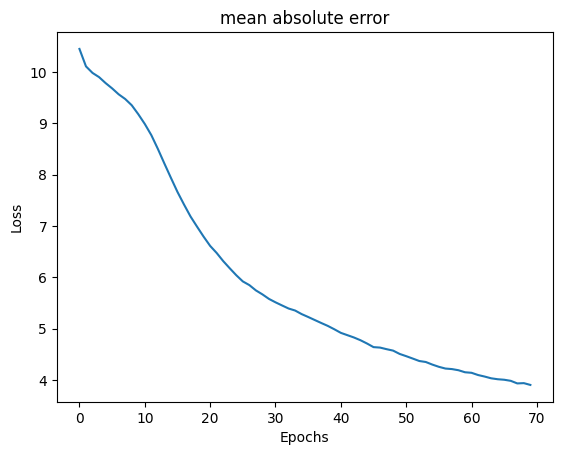

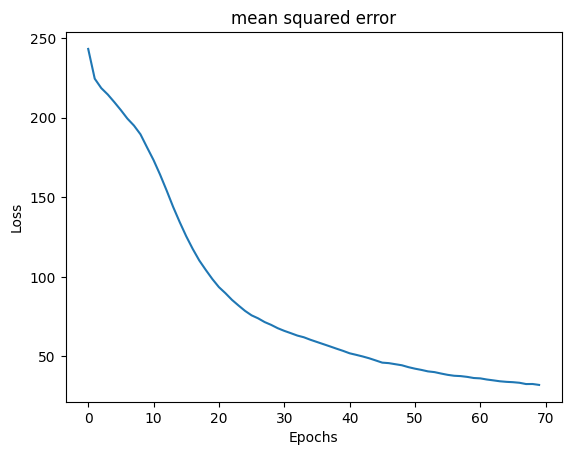

In [30]:
model_name = 'FINAL-CIFAR-L2'
torch.save(model.state_dict(), f'models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'plots/L2-{model_name}.png')

In [31]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images.to(device)
            colors = colors.to(device)

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images.cpu(), predicted_colors.cpu(), to_numpy = False)
            label_rgb = to_rgb(grayscale_images.cpu(), colors.cpu(), to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item() / len(loss)

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [35]:

testloader = DataLoader(test_data, batch_size=256)
lpips_score = lpips_evaluate(model, testloader)

print(f'LPIPS results on test data:{lpips_score}')

LPIPS results on test data:0.0514141833409667


torch.Size([2, 32, 32])
2516


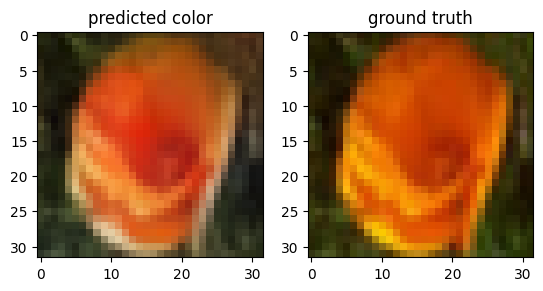

In [50]:
import random
model.eval()

index = random.randint(0,len(test_data))
input, label = test_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input.unsqueeze(0)).squeeze()
print(output.shape)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2)


axes[0].imshow(rgb_pred)
axes[0].set_title('predicted color')

axes[1].imshow(rgb_label)
axes[1].set_title('ground truth')
print(index)